In [1]:
%matplotlib inline

In [2]:
import sys
sys.path.insert(0, "../")
sys.path.insert(0, "../dataset_generator/")
import environments

import torch
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

plt.style.use("project_style.mplstyle")

import scipy.stats
import stats

from tqdm import tqdm
import analysis_tools

from astropy.convolution import Gaussian2DKernel, convolve

In [3]:
model_name = f"../models/al1_10_l2_0"
path = f"../models/{model_name}"
model, params = analysis_tools.load_model(path, device = "cpu", model_type = "RNN")

## Elongation experiment

In [4]:
timesteps = 500_000
env = environments.Environments()

In [5]:
sequence = ["square"]

In [6]:
scales = [1, 2, 3, 3.5] # scaling relative to square
y_bins = np.linspace(-1, 1, 10) # no y stretch

p_maps = []
g_maps = []

for scale in scales:
    env = environments.Environments()
    env.envs["square"]= env.envs["square"]*np.array([scale, 1])[None,None] # stretch walls of environment!
    x, r, v, c = analysis_tools.test_dataset(sequence, timesteps = timesteps, context = params["context"], env = env) # create dataset
    dataset = [((x[0][i,None], x[1][i,None]), x[1][i,None]) for i in range(len(sequence))] # repackage
    gs, ps, centers, preds = model.inference(dataset)

    # extra bins for stretched environment, x-direction!
    x_bins = np.linspace(-scale, scale, int(scale*10))
    stretch_bins = [[x_bins, y_bins]]
    
    p_maps.append(stats.ratemaps(ps, r, stretch_bins).squeeze())
    g_maps.append(stats.ratemaps(gs, r, stretch_bins).squeeze())

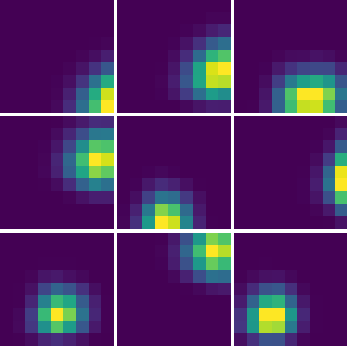

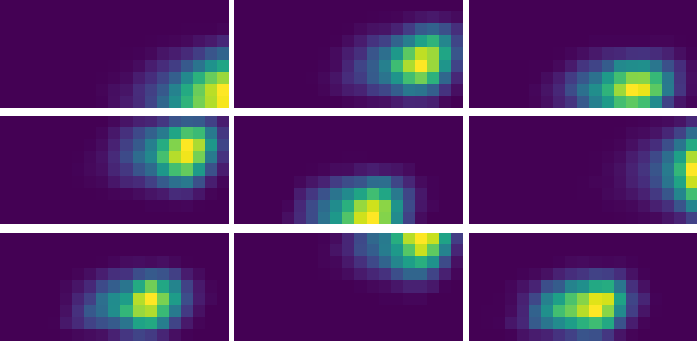

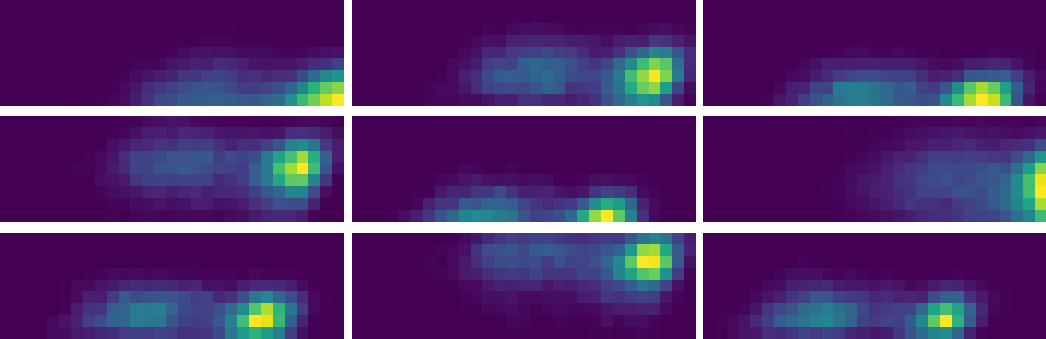

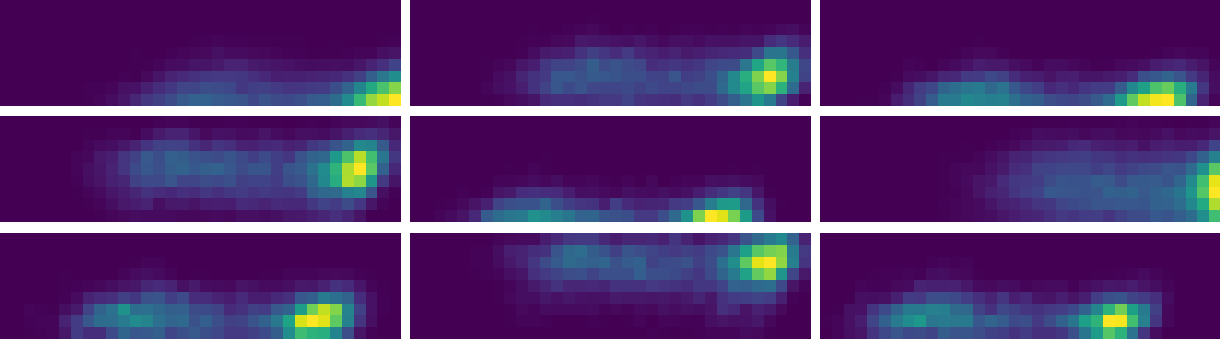

In [19]:
mask = np.argsort(np.nansum(p_maps[0], axis = (-2, -1)))[::-1]

for i, p in enumerate(p_maps):
    analysis_tools.plot_ensemble(p[mask], n = 3, pane_size=(scales[i]*0.5, 0.5))
    plt.subplots_adjust(hspace = 0.03, wspace = 0.025)
    plt.savefig(f"./figures/stretch_panel/square_p_{str(scales[i]).replace('.', '_')}")

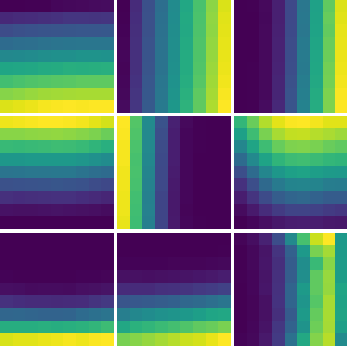

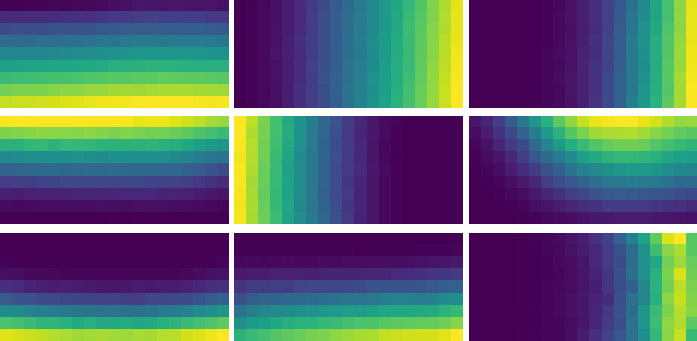

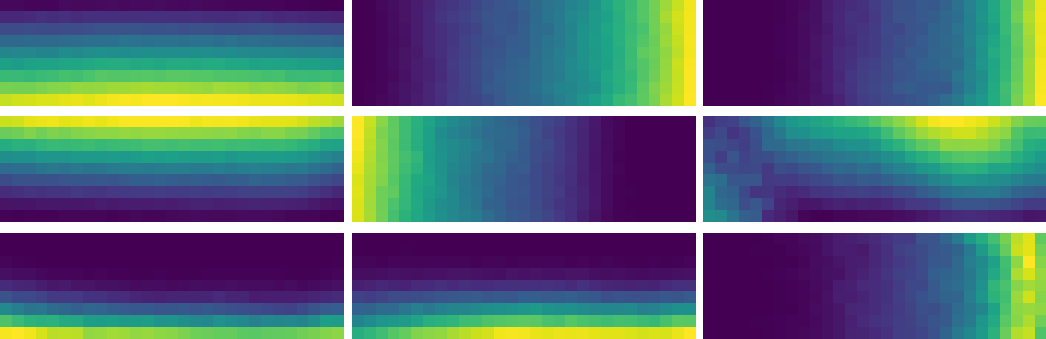

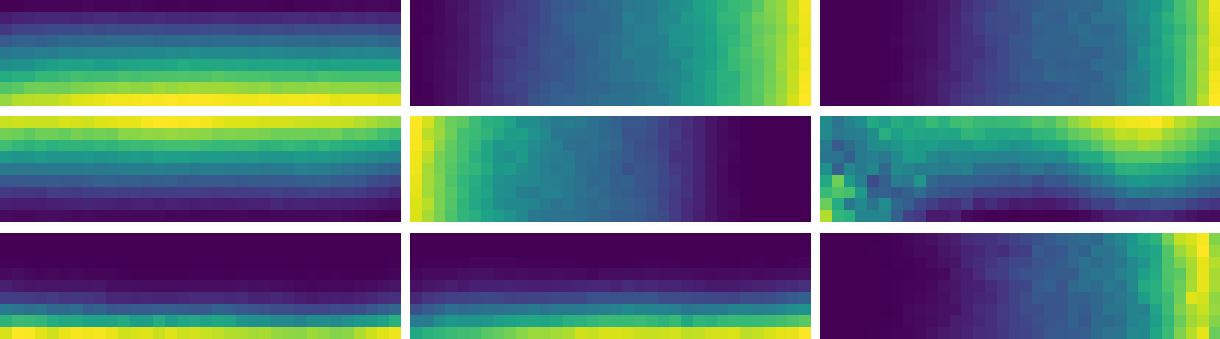

In [8]:
mask = np.argsort(np.nansum(g_maps[0], axis = (-2, -1)))[::-1][3:]
for i, g in enumerate(g_maps):
    analysis_tools.plot_ensemble(g[mask], n = 3, pane_size=(scales[i]*0.5, 0.5))
    plt.subplots_adjust(hspace = 0.03, wspace = 0.025)
    plt.savefig(f"./figures/stretch_panel/square_g_{str(scales[i]).replace('.', '_')}")

In [9]:
# Elongate in both x and y directions

scales = [1, 2, 3, 3.5] # scaling relative to square

l_p_maps = []
l_g_maps = []

for scale in scales:
    env = environments.Environments()
    env.envs["square"]= env.envs["square"]*np.array([scale, scale])[None,None] # stretch walls of environment!
    x, r, v, c = analysis_tools.test_dataset(sequence, timesteps = timesteps, context = params["context"], env = env) # create dataset
    dataset = [((x[0][i,None], x[1][i,None]), x[1][i,None]) for i in range(len(sequence))] # repackage
    gs, ps, centers, preds = model.inference(dataset)

    # extra bins for stretched environment
    x_bins = np.linspace(-scale, scale, int(scale*10))
    y_bins = np.linspace(-scale, scale, int(scale*10))
    stretch_bins = [[x_bins, y_bins]] 
    
    l_p_maps.append(stats.ratemaps(ps, r, stretch_bins).squeeze())
    l_g_maps.append(stats.ratemaps(gs, r, stretch_bins).squeeze())

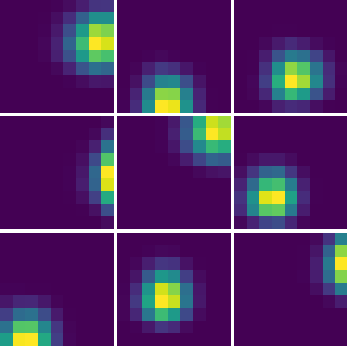

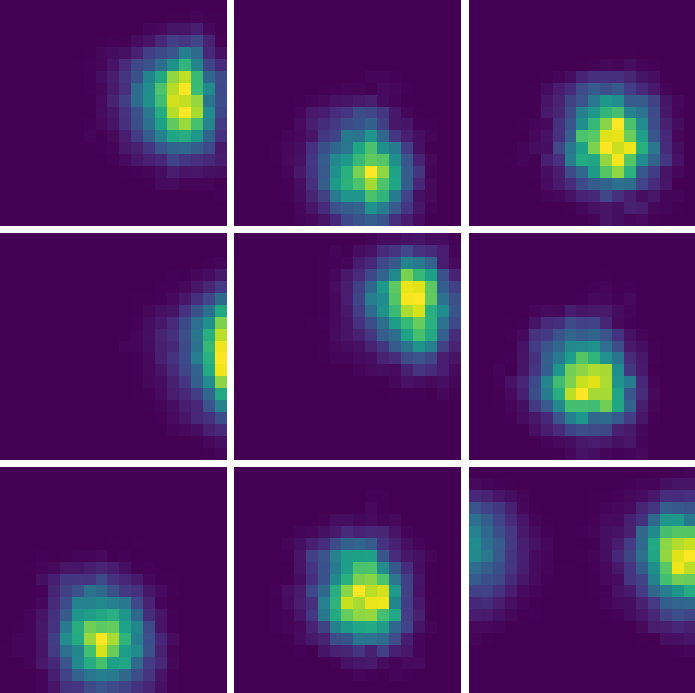

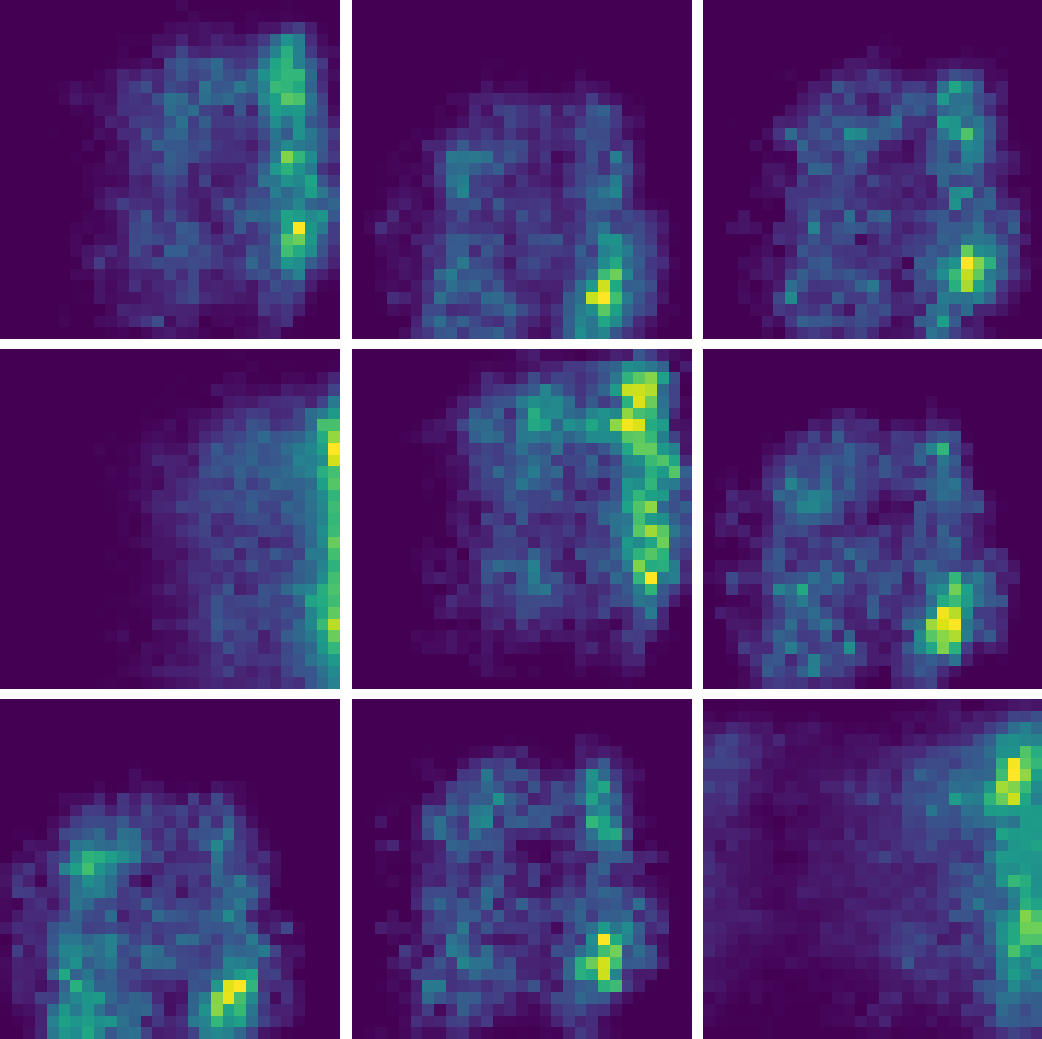

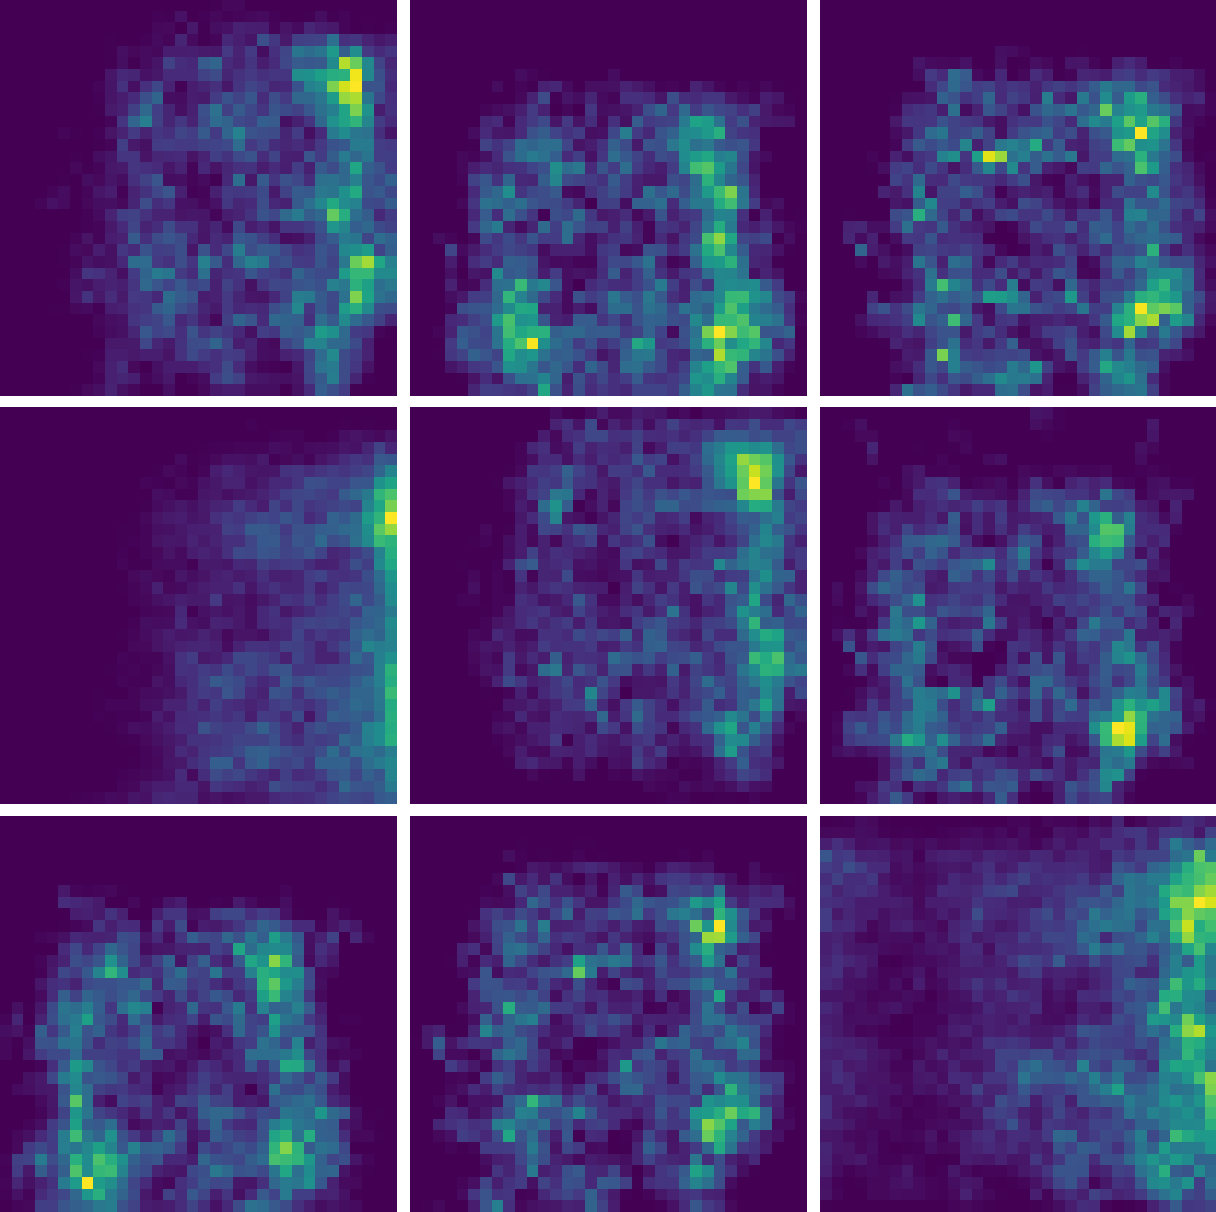

In [20]:
mask = np.argsort(np.nansum(l_p_maps[0], axis = (-2, -1)))[::-1][3:]

for i, p in enumerate(l_p_maps):
    analysis_tools.plot_ensemble(p[mask], n = 3, pane_size=(scales[i]*0.5, scales[i]*0.5))
    plt.subplots_adjust(hspace = 0.03, wspace = 0.025)
    plt.savefig(f"./figures/stretch_panel/large_square_p_{str(scales[i]).replace('.', '_')}")    

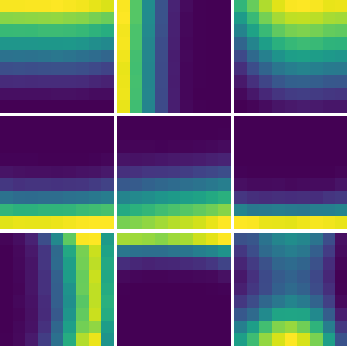

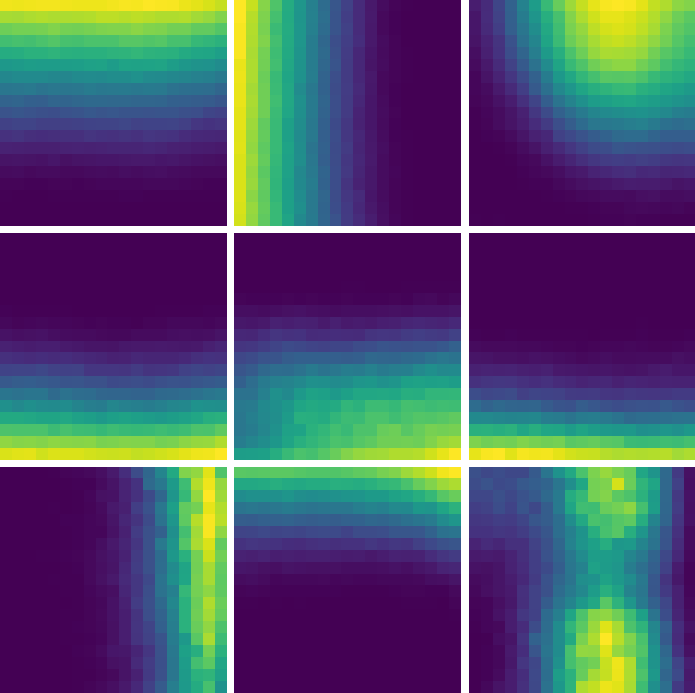

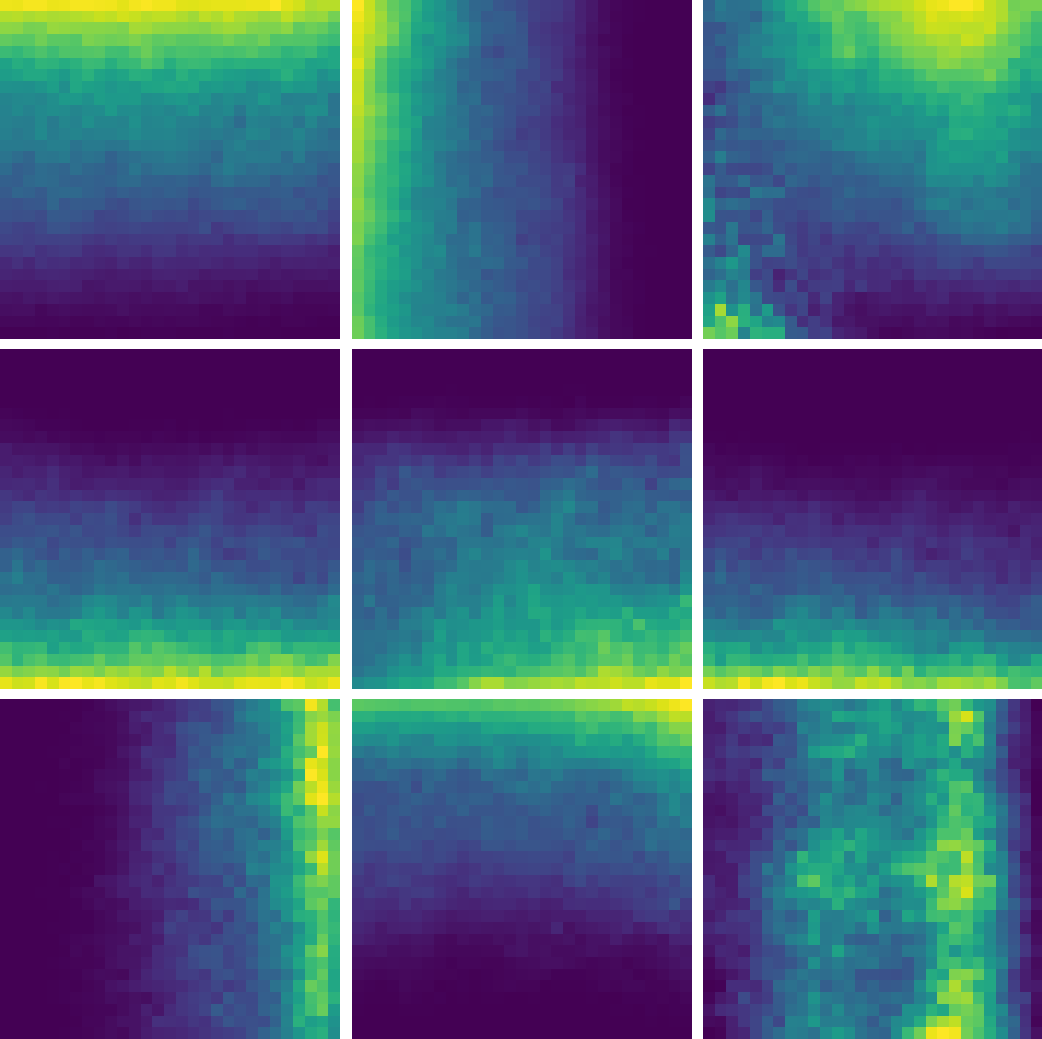

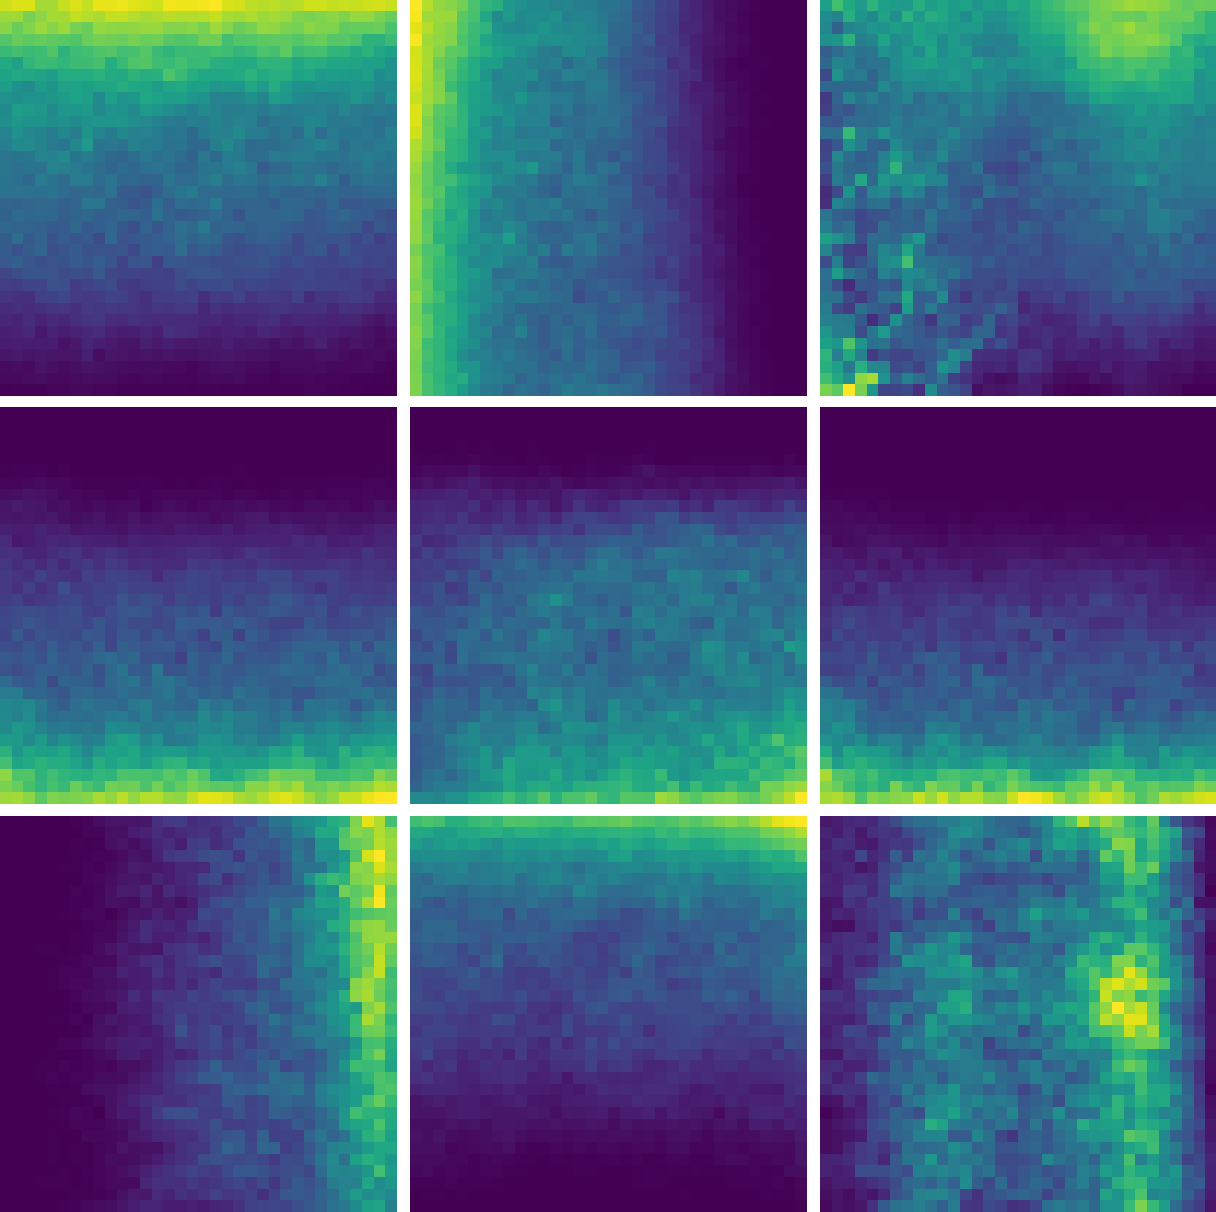

In [21]:
mask = np.argsort(np.nansum(l_g_maps[0], axis = (-2, -1)))[::-1][3:]
for i, g in enumerate(l_g_maps):
    analysis_tools.plot_ensemble(g[mask], n = 3, pane_size=(scales[i]*0.5, scales[i]*0.5))
    plt.subplots_adjust(hspace = 0.03, wspace = 0.025)
    plt.savefig(f"./figures/stretch_panel/large_square_g_{str(scales[i]).replace('.', '_')}")

In [12]:
# Elongate in both x and y directions
# extra bins for stretched environment
x_bins = np.linspace(-1, 1, 32)
y_bins = np.linspace(-1, 1, 32)
bins = [[x_bins, y_bins]] 


t_p_maps = []
t_g_maps = []

env = environments.Environments()
x, r, v, c = analysis_tools.test_dataset(["square_toroid"], timesteps = 20000, context = params["context"], env = env) # create dataset

## square toroid
dataset = [((x[0][i,None], x[1][i,None]), x[1][i,None]) for i in range(len(sequence))] # repackage
gs, ps, centers, preds = model.inference(dataset)
t_p_maps.append(stats.ratemaps(ps, r, bins).squeeze())
t_g_maps.append(stats.ratemaps(gs, r, bins).squeeze())

x, r, v, c = analysis_tools.test_dataset(sequence, timesteps = 20000, context = params["context"], env = env) # create dataset
# square, switch to toroid context!
x[0][...,2:] = torch.tensor((np.arange(6) == 5)[None, None])
dataset = [((x[0][i,None], x[1][i,None]), x[1][i,None]) for i in range(len(sequence))] # repackage
gs, ps, centers, preds = model.inference(dataset)
t_p_maps.append(stats.ratemaps(ps, r, bins).squeeze())
t_g_maps.append(stats.ratemaps(gs, r, bins).squeeze())

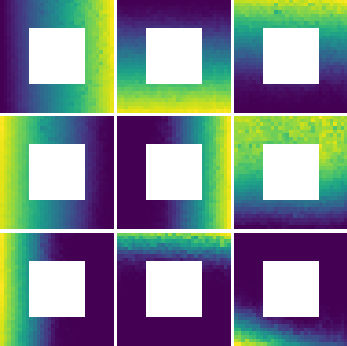

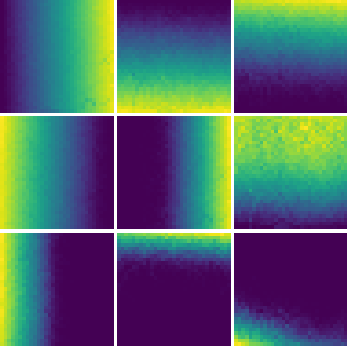

In [13]:
mask = np.argsort(np.nansum(t_g_maps[1], axis = (-2, -1)))[::-1]

for i, g in enumerate(t_g_maps):
    analysis_tools.plot_ensemble(g[mask], n = 3, pane_size=(0.5, 0.5))
    plt.subplots_adjust(hspace = 0.03, wspace = 0.025)
    plt.savefig(f"./figures/stretch_panel/toroid_g_{str(scales[i]).replace('.', '_')}")

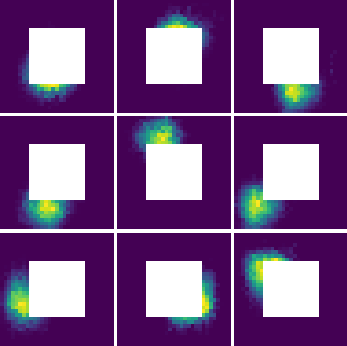

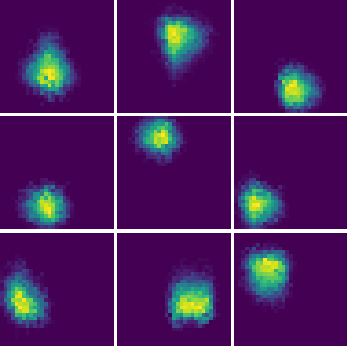

In [14]:
mask = np.argsort(np.nansum(t_p_maps[1], axis = (-2, -1)))[::-1]

for i, p in enumerate(t_p_maps):
    analysis_tools.plot_ensemble(p[mask], n = 3, pane_size=(0.5,0.5))
    plt.subplots_adjust(hspace = 0.03, wspace = 0.025)
    plt.savefig(f"./figures/stretch_panel/toroid_p_{str(scales[i]).replace('.', '_')}")

In [15]:
# Elongate in both x and y directions

scales = [1, 2, 3, 3.5] # scaling relative to square

c_p_maps = []
c_g_maps = []

for scale in scales:
    env = environments.Environments()
    env.envs["circle"]= env.envs["circle"]*scale # stretch walls of environment!

    x, r, v, c = analysis_tools.test_dataset(["circle"], timesteps = timesteps, context = params["context"], env = env) # create dataset
    dataset = [((x[0][i,None], x[1][i,None]), x[1][i,None]) for i in range(len(sequence))] # repackage
    gs, ps, centers, preds = model.inference(dataset)

    # extra bins for stretched environment
    x_bins = np.linspace(-scale, scale, int(scale*10))
    y_bins = np.linspace(-scale, scale, int(scale*10))
    stretch_bins = [[x_bins, y_bins]]
    
    c_p_maps.append(stats.ratemaps(ps, r, stretch_bins).squeeze())
    c_g_maps.append(stats.ratemaps(gs, r, stretch_bins).squeeze())

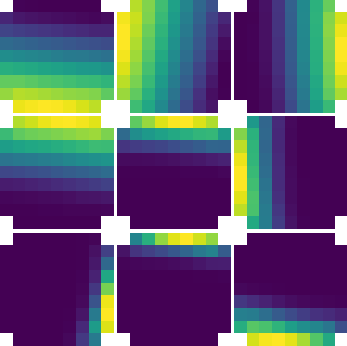

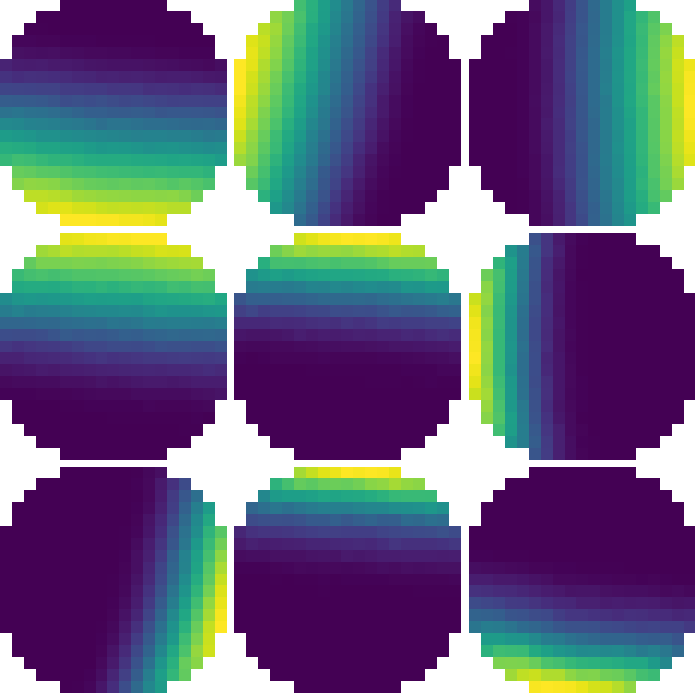

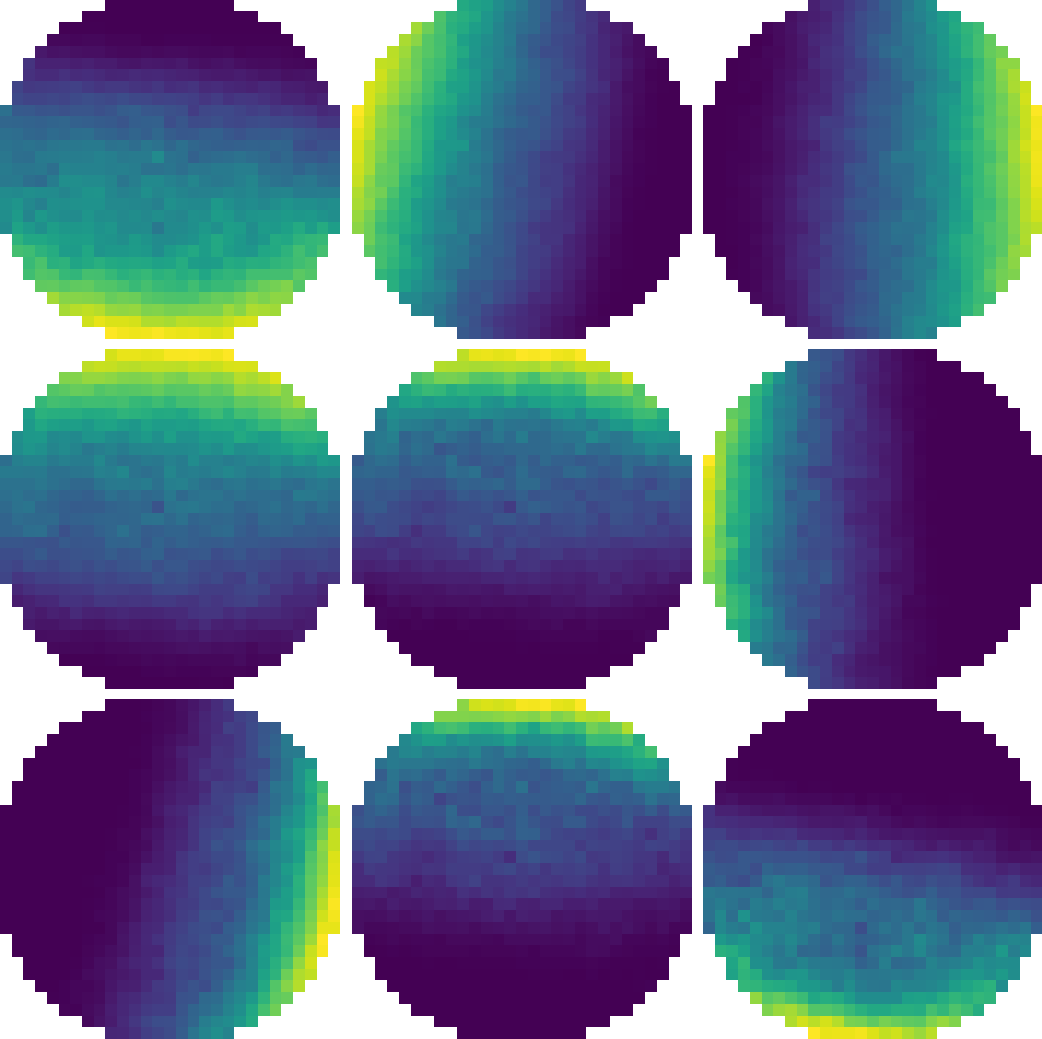

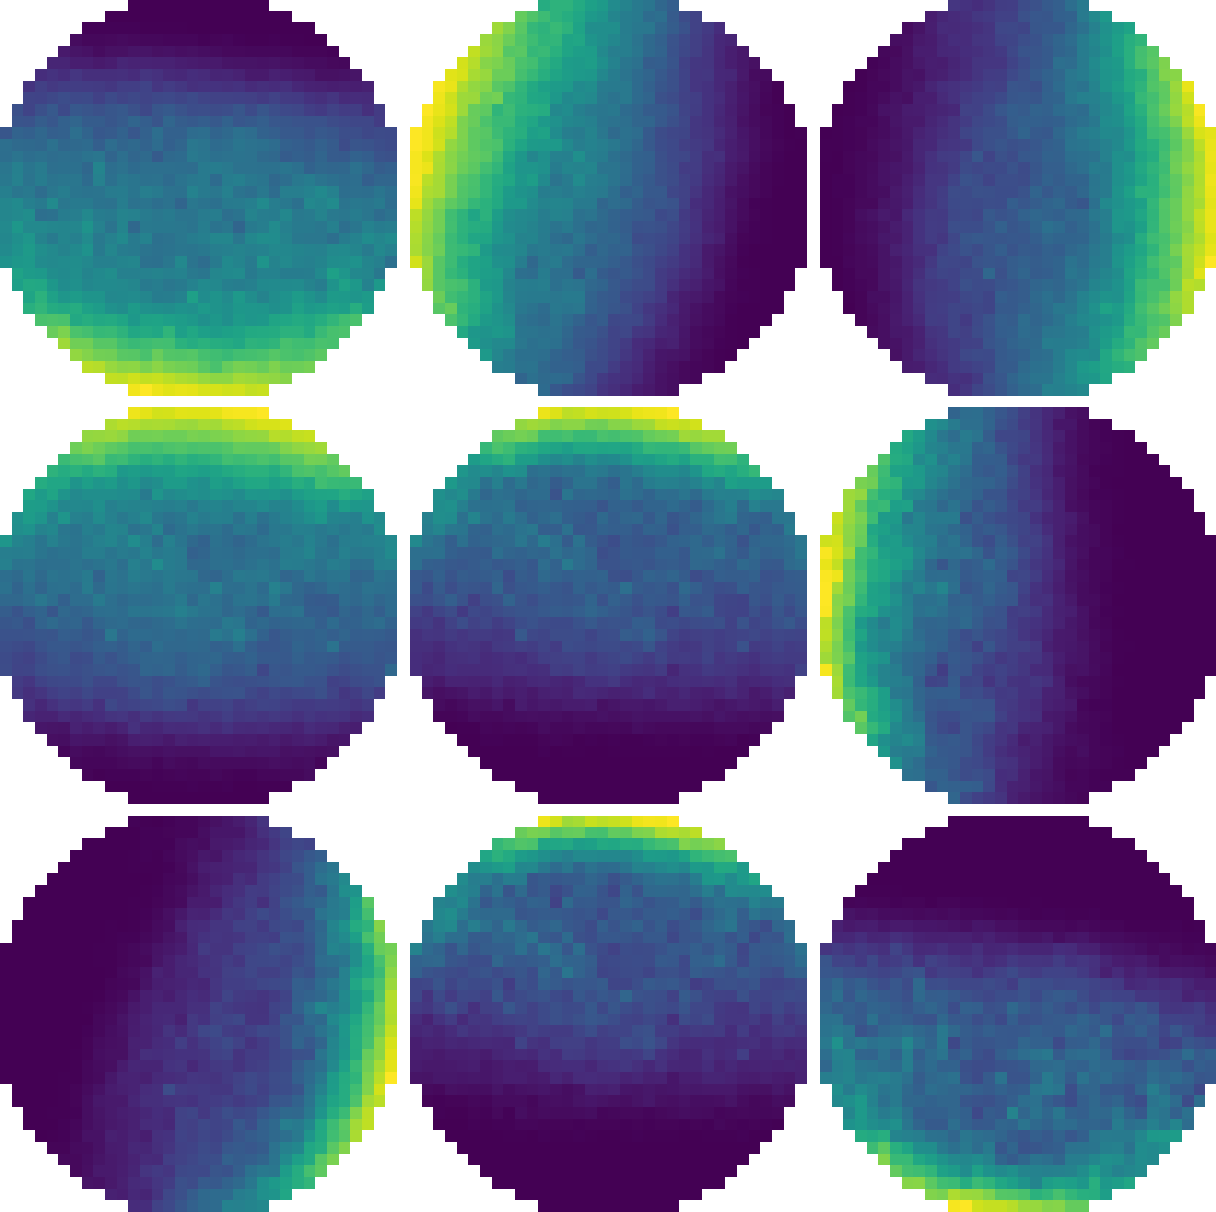

In [23]:
mask = np.argsort(np.nansum(c_g_maps[1], axis = (-2, -1)))[::-1]

for i, g in enumerate(c_g_maps):
    analysis_tools.plot_ensemble(g[mask], n = 3, pane_size=(scales[i]*0.5,scales[i]*0.5))
    plt.subplots_adjust(hspace = 0.03, wspace = 0.025)
    plt.savefig(f"./figures/stretch_panel/circle_g_{str(scales[i]).replace('.', '_')}")

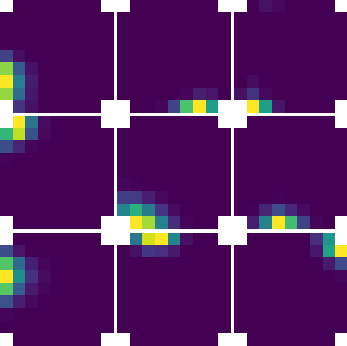

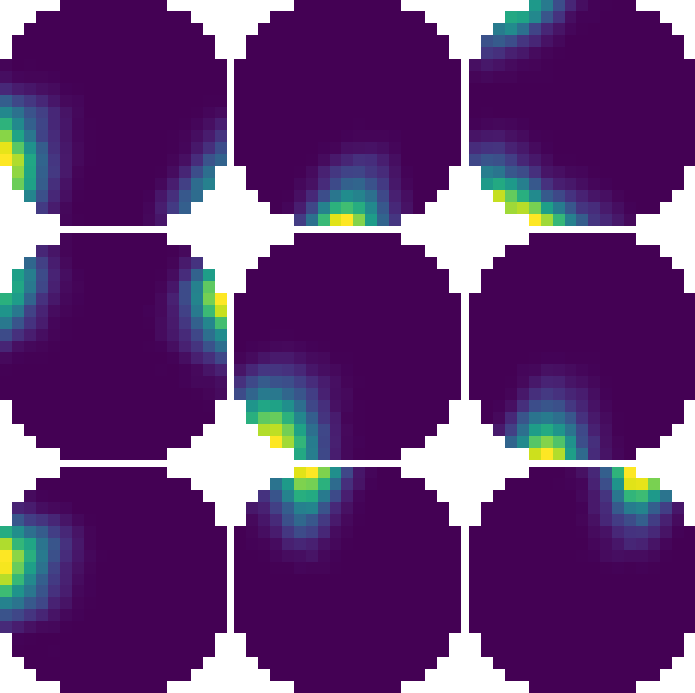

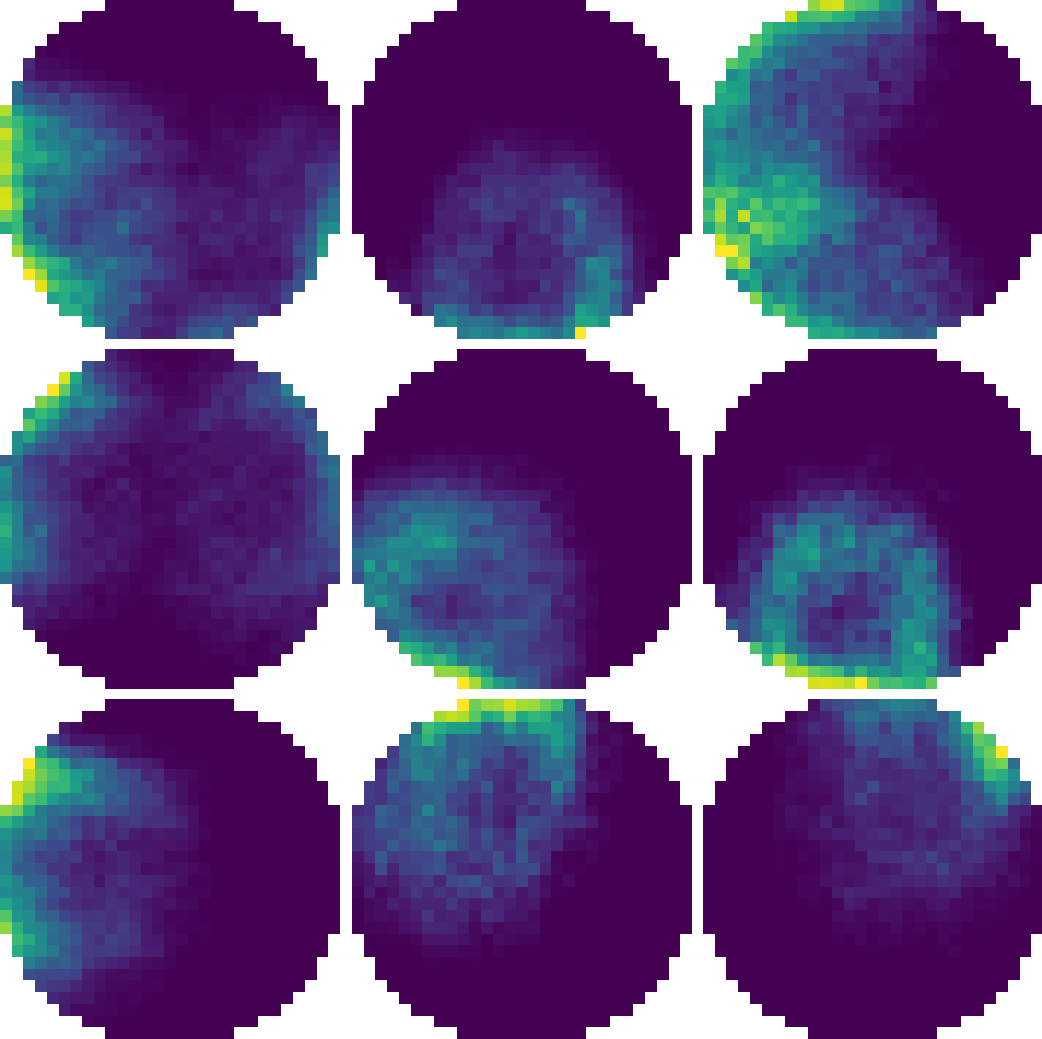

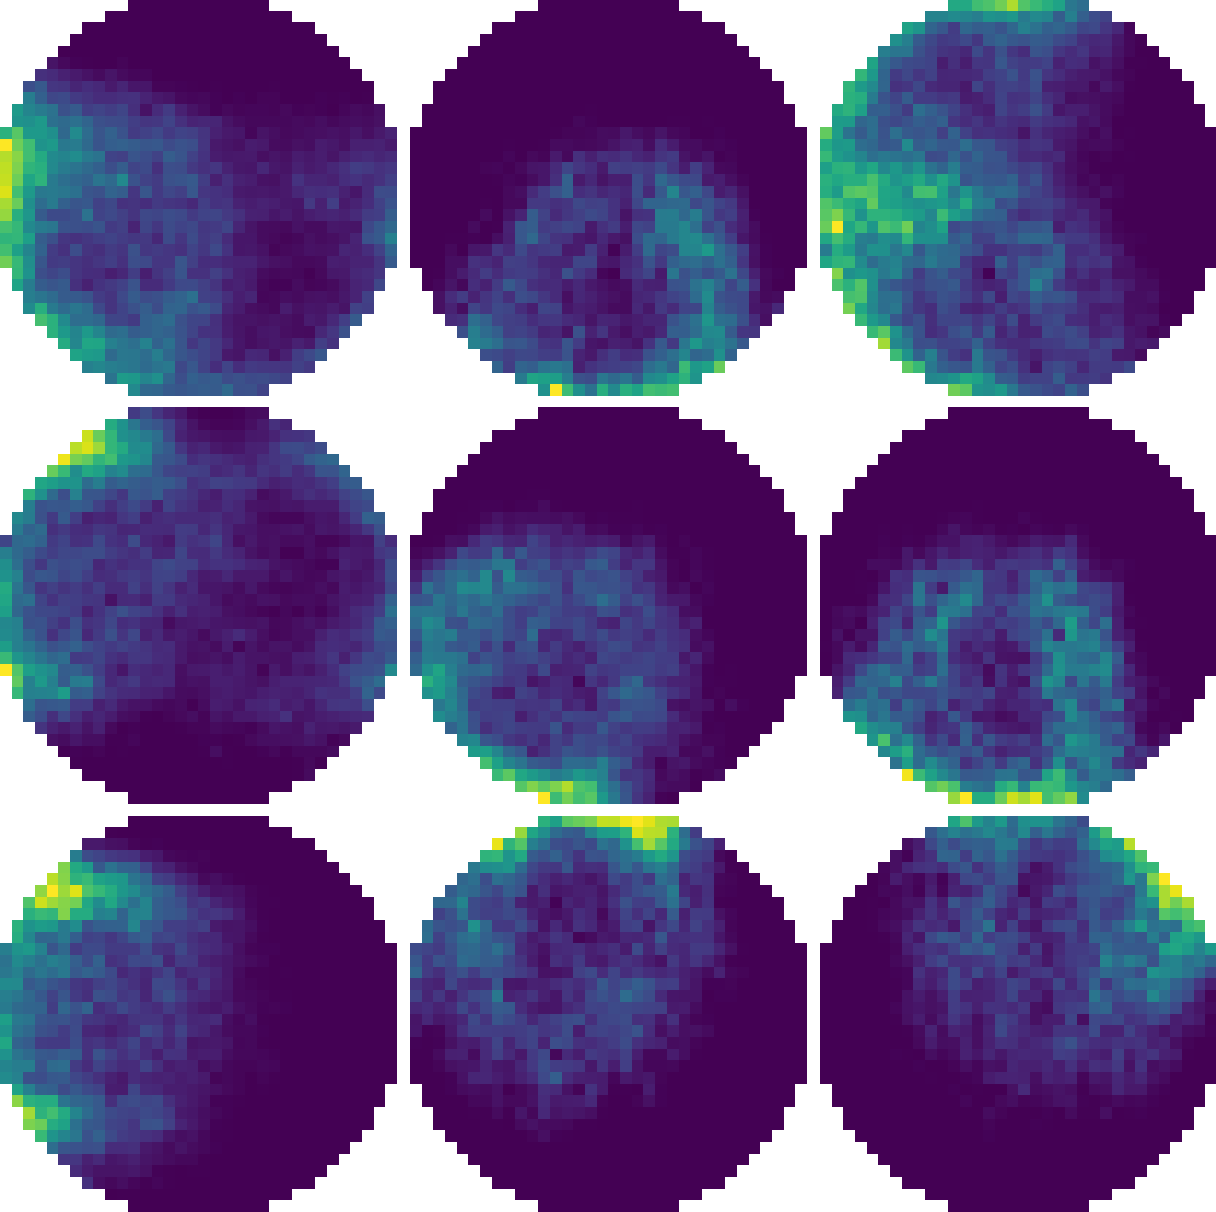

In [17]:
mask = np.argsort(np.nansum(c_p_maps[1], axis = (-2, -1)))[::-1]

for i, p in enumerate(c_p_maps):
    analysis_tools.plot_ensemble(p[mask], n = 3,pane_size=(scales[i]*0.5,scales[i]*0.5))
    plt.subplots_adjust(hspace = 0.03, wspace = 0.025)
    plt.savefig(f"./figures/stretch_panel/circle_p_{str(scales[i]).replace('.', '_')}")